# Plot the outcomes of individual test sites

In [1]:
import os
import xarray as xr
from glob import glob
import pandas as pd
import numpy as np
from shared_read_HBR import *
from matplotlib import rcParams
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm
import itertools as it

rcParams['font.size'] = 14
rcParams['axes.titlesize'] = 14

# soil layer depths in ELM
zsoi = np.array([0.0071, 0.0279, 0.0623, 0.1189, 0.2122, 0.3661, 0.6198, 1.0380, 1.7276, 2.8646])
zisoi = np.array([0.0175, 0.0451, 0.0906, 0.1655, 0.2891, 0.4929, 0.8289, 1.3828, 2.2961, 3.8019])
dzsoi = np.array([0.0175, 0.0276, 0.0455, 0.0750, 0.1236, 0.2038, 0.3360, 0.5539, 0.9133, 1.5058])

# major cation list
cations = ['Ca2+','Mg2+','Na+','K+','Al3+']

# list of interested sites
site_list = pd.read_csv(os.path.join(os.environ['E3SM_ROOT'], 'inputdata', 'lnd', 
                                     'clm2', 'PTCLM', 'ERW_sitedata.txt'), 
                        index_col = 0)
# path to save the graphs
path_out = os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'results', 'plotTestSites')

# list of NetCDF file names generated by ELM
date_prefix = '20240915'
folder_list = dict([
    (site, 
     [os.path.join(os.environ['E3SM_ROOT'], 'output', 
                  f'{date_prefix}_{site}_ICB20TRCNPRDCTCBC_erw', 'run',
                  f'{date_prefix}_{site}_ICB20TRCNPRDCTCBC_erw.elm.h1.{year}-01-01-00000.nc') \
                    for year in range(1985, 2015)]
    ) for site in site_list.index
])
tvec = pd.date_range('1985-01-01', '2014-12-31', freq = '1D')
tvec = tvec[(tvec.month != 2) & (tvec.month != 29)]

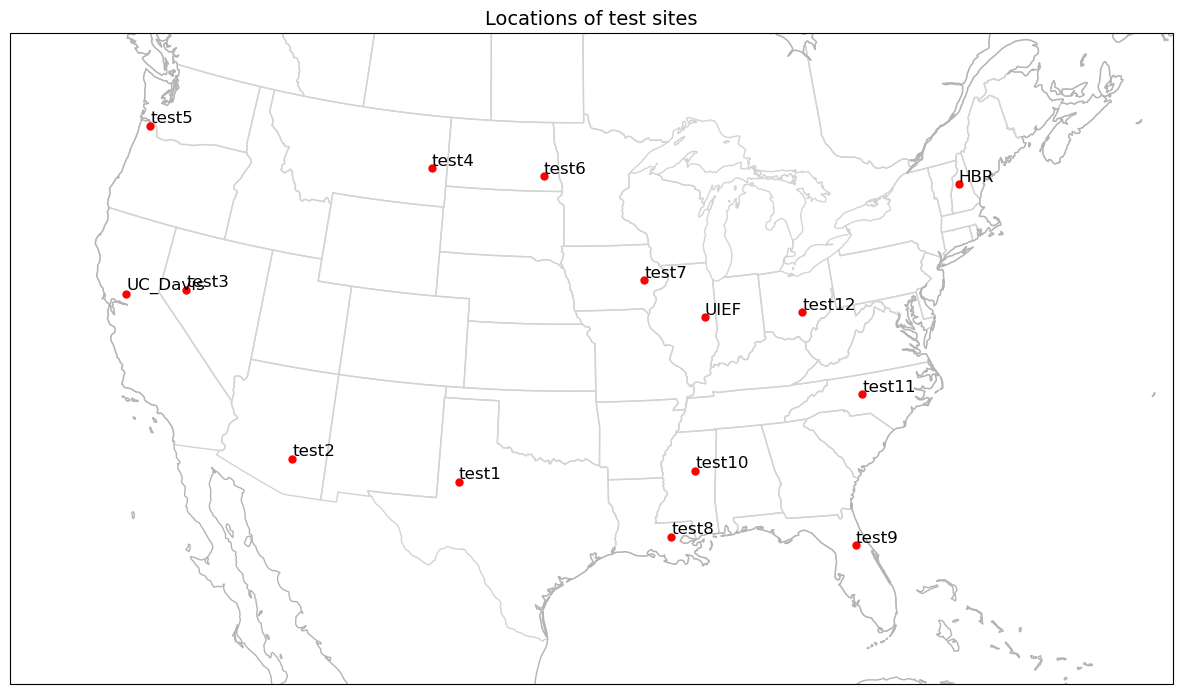

<Figure size 640x480 with 0 Axes>

In [2]:
# Convert longitudes from 0-360 to -180-180 range
site_list['lon'] = (site_list['lon'] + 180) % 360 - 180

fig, ax = plt.subplots(figsize=(15, 10), subplot_kw={'projection': ccrs.LambertConformal()})
ax.add_feature(cfeature.STATES, edgecolor='lightgrey', facecolor='none')
ax.add_feature(cfeature.COASTLINE, edgecolor=(0.7, 0.7, 0.7), facecolor='none')
ax.set_extent([-123, -67, 24, 50], crs=ccrs.PlateCarree())
for ind, row in site_list.iterrows():
    ax.plot(row['lon'], row['lat'], 'ro', transform=ccrs.PlateCarree(), markersize=5)
    ax.text(row['lon'], row['lat'], ind, transform=ccrs.PlateCarree(), 
            fontsize=12, ha='left', va='bottom')
plt.title('Locations of test sites')
plt.show()
plt.savefig(os.path.join(path_out, 'location_of_test_sites.png'), dpi = 600., bbox_inches = 'tight')
#plt.close()

# 1. Hydrological balance

In [3]:
# unit - mm/year
hydro = pd.DataFrame(np.nan, index = site_list.index, 
                     columns = ['P', 'ET', 'QOVER', 'QDRAI'])
vwc = pd.DataFrame(np.nan, columns = site_list.index,
                   index = pd.MultiIndex.from_product([range(1,13),range(1,11)]))
for site in site_list.index:
    hr = xr.open_mfdataset(folder_list[site])
    hydro.loc[site, 'P'] = (hr['RAIN'].values + hr['SNOW'].values).mean(axis = 0) * 86400 * 365
    hydro.loc[site, 'ET'] = (hr['QVEGE'].values + hr['QVEGT'].values + hr['QSOIL'].values
                             ).mean(axis = 0) * 86400 * 365
    hydro.loc[site, 'QOVER'] = hr['QOVER'].mean(axis = 0).values * 86400 * 365
    hydro.loc[site, 'QDRAI'] = hr['QDRAI'].mean(axis = 0).values * 86400 * 365
    vwc.loc[:, site] = hr['H2OSOI'].groupby('time.month').mean()[:, :10, 0].values.reshape(-1)
    hr.close()

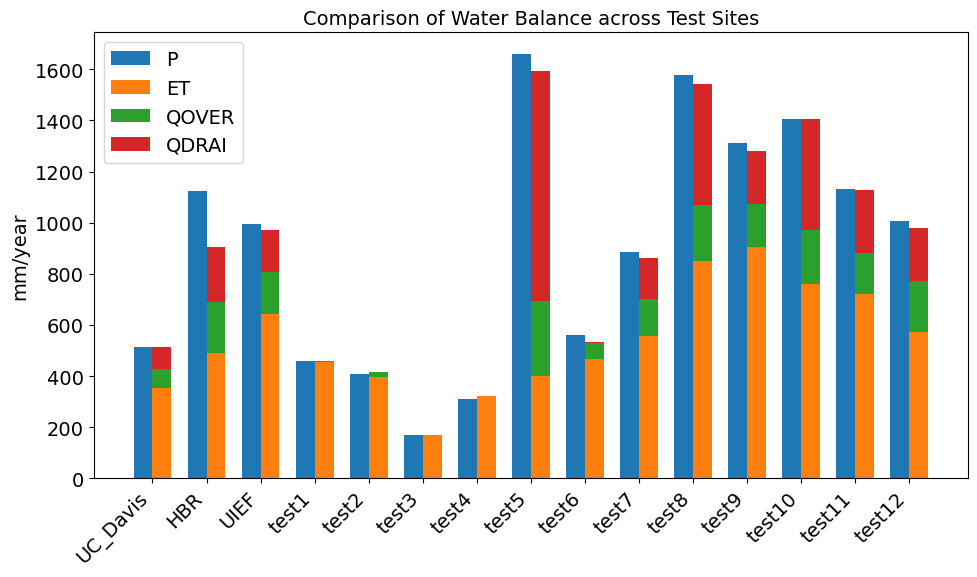

<Figure size 640x480 with 0 Axes>

In [4]:
fig, ax = plt.subplots(figsize=(10, 6))
width = 0.35
ind = range(len(hydro))

p1 = ax.bar(ind, hydro['P'], width, label='P')
p2 = ax.bar([i + width for i in ind], hydro['ET'], width, label='ET')
p3 = ax.bar([i + width for i in ind], hydro['QOVER'], width, bottom=hydro['ET'], label='QOVER')
p4 = ax.bar([i + width for i in ind], hydro['QDRAI'], width, bottom=hydro['ET'] + hydro['QOVER'],
            label='QDRAI')

ax.set_ylabel('mm/year')
ax.set_title('Comparison of Water Balance across Test Sites')
ax.set_xticks([i + width/2 for i in ind])
ax.set_xticklabels(hydro.index, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

plt.savefig(os.path.join(path_out, 'compare_water_balance.png'), dpi = 600., bbox_inches = 'tight')

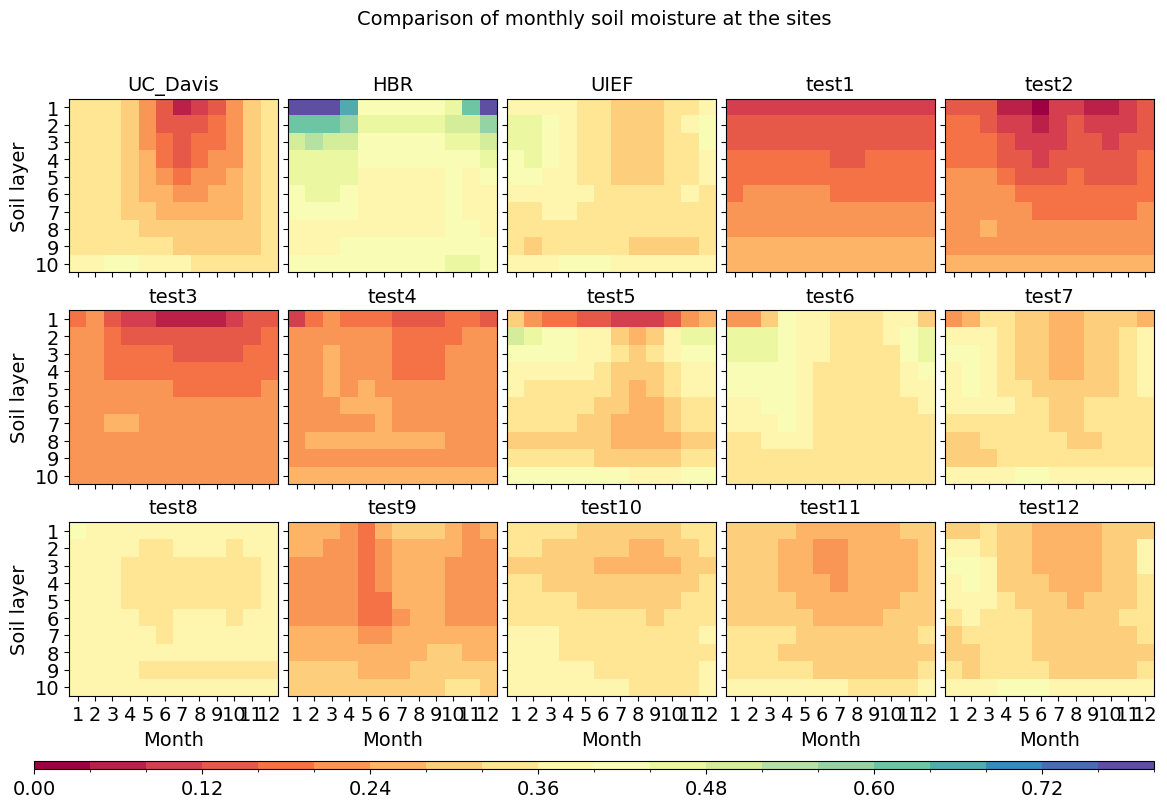

In [5]:
norm = BoundaryNorm(np.linspace(0, 0.8, 21), ncolors = 256, clip = True)

clist = ['#543005', '#8c510a', '#bf812d', '#dfc27d', '#f6e8c3', '#c7eae5',
         '#80cdc1', '#35978f', '#01665e', '#003c30']
fig, axes = plt.subplots(3, 5, figsize = (14, 8), sharex = True, sharey = True)
fig.subplots_adjust(wspace = 0.05, hspace = 0.1)
for i, site in enumerate(site_list.index):
    ax = axes.flat[i]
    cf = ax.imshow(vwc[site].unstack().values.T, norm = norm, cmap = 'Spectral')
    ax.set_title(site)
    ax.set_xticks(range(12))
    ax.set_xticklabels(range(1,13))
    ax.set_yticks(range(10))
    ax.set_yticklabels(range(1,11))
    if np.mod(i, 5) == 0:
        ax.set_ylabel('Soil layer')
    if i >= 10:
        ax.set_xlabel('Month')
cax = fig.add_axes([0.1, 0.03, 0.8, 0.01])
plt.colorbar(cf, cax = cax, orientation = 'horizontal')
fig.suptitle('Comparison of monthly soil moisture at the sites', fontsize = 14)

plt.savefig(os.path.join(path_out, 'compare_vwc.png'), dpi = 600., bbox_inches = 'tight')

# 2. Cation balance

## 2.1 Target variable: `r_sequestration`

In [6]:
# gC m-2 s-1 => ton ha-1 yr-1
r_sequestration = pd.DataFrame(np.nan, columns = site_list.index, index = range(1985, 2015))
for site in site_list.index:
    hr = xr.open_mfdataset(folder_list[site])
    r_sequestration.loc[:, site] = hr['r_sequestration'].resample(time = '1Y').mean().values  \
        * 86400 * 365 / 100
    hr.close()

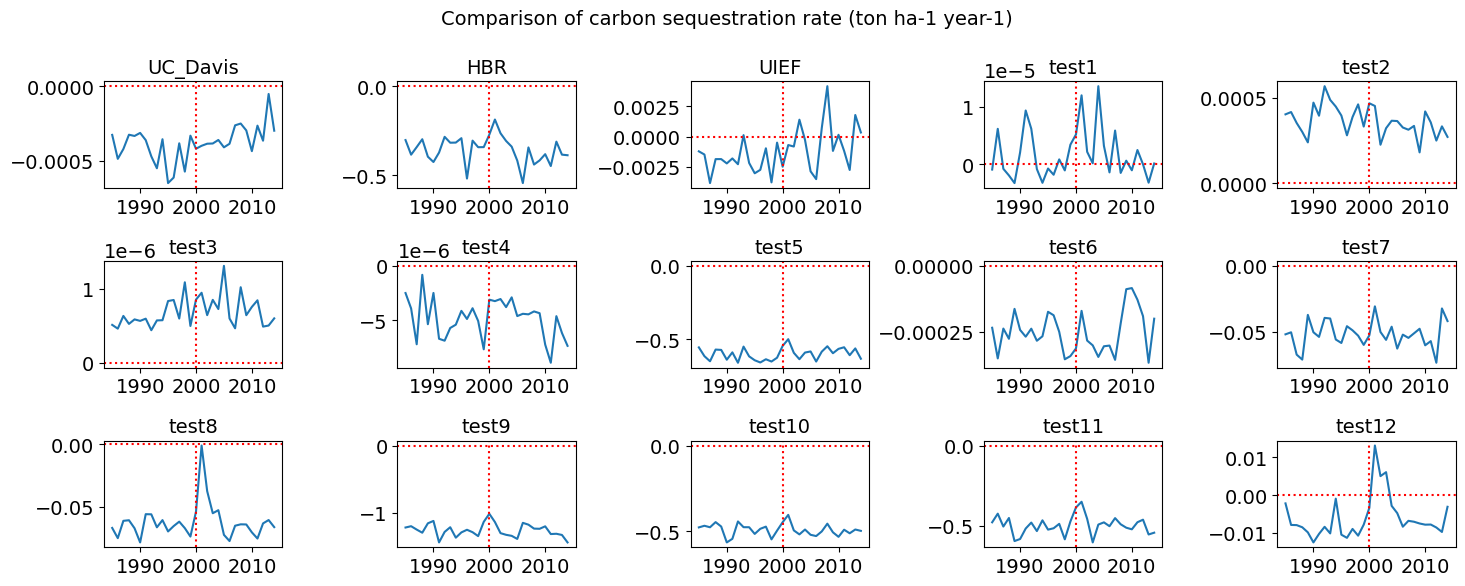

In [7]:
fig, axes = plt.subplots(3, 5, figsize = (15, 6))
for i, site in enumerate(site_list.index):
    ax = axes.flat[i]
    ax.plot(r_sequestration.index, r_sequestration[site])
    ax.set_title(site)
    ax.axhline(0, color = 'r', ls = ':')
    ax.axvline(2000, color = 'r', ls = ':')
fig.suptitle('Comparison of carbon sequestration rate (ton ha-1 year-1)', fontsize = 14)
plt.tight_layout()
plt.savefig(os.path.join(path_out, 'compare_r_sequestration.png'), 
            dpi = 600., bbox_inches = 'tight')
#plt.close()

## 2.2 Primary mineral dissolution

Integrated over all the layers (primary mineral only exists until mixing depth - the top six layers)

In [8]:
minerals_name = ['Wollastonite_CaSiO3', 'Forsterite_Mg2SiO4', 'Albite_NaAlSi3O8', 
                 'Anorthite_CaAl2Si2O8', 'Epidote_Ca2FeAl2(SiO4)3(OH)', 'Calcite_CaCO3',
                 'Labradorite_Ca0.6Na0.4Al1.6Si2.4O8', 'Augite_Ca0.9Mg0.9Na0.1Al0.4Fe0.2Si1.9O6',
                 'Kfeldspar_KAlSi3O8', 'Enstatite_MgSiO3']
# normal alkali basalt (fast)
# pct_basalt = np.array([0, 12, 0, 0, 0, 0, 43, 21, 6, 0])

# ! Need to correct: the other three are not saved! 
mineral_list = [2] # [2, 7, 8, 9]

In [9]:
# g Rock m-2 => ton ha-1
# Resample using "max()" to get the start value in each month
primary_mineral = pd.DataFrame(np.nan, 
    index = pd.date_range('1999-01-01', '2014-12-31', freq='1MS'),
    columns = pd.MultiIndex.from_product([mineral_list, site_list.index]))
for min,site in it.product(mineral_list, site_list.index):
    hr = xr.open_mfdataset(folder_list[site])
    temp = hr[f'primary_mineral_vr_{min}'][hr['time'].to_index().year >= 1999, :10, 
                                           0].resample(time = '1M').max().values/100
    temp = np.sum(temp * dzsoi.reshape(1, -1), axis = 1)
    primary_mineral.loc[:, (min,site)] = temp
    hr.close()

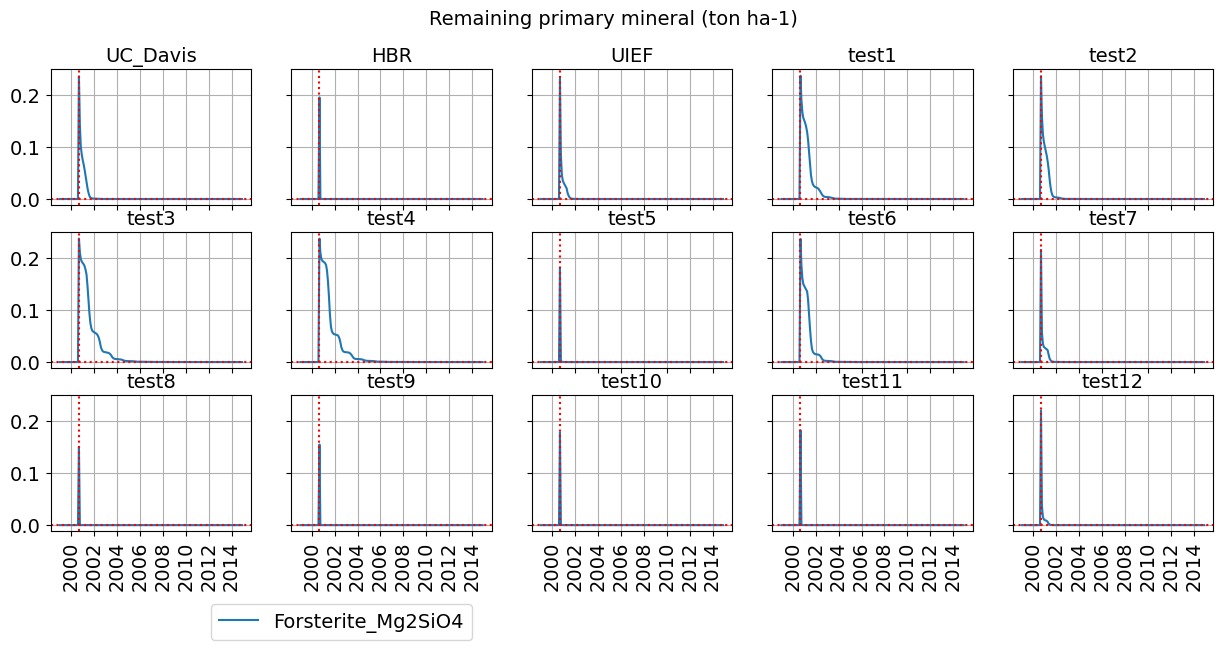

In [10]:
fig, axes = plt.subplots(3, 5, figsize = (15, 6), sharex = True, sharey = True)
for i, site in enumerate(site_list.index):
    ax = axes.flat[i]
    h = []
    for min in mineral_list:
        temp, = ax.plot(primary_mineral.index, primary_mineral[(min,site)])
        h.append(temp)
    ax.set_title(site)
    ax.axhline(0, color = 'r', ls = ':')
    ax.axvline(pd.Timestamp('2000-09-01'), color = 'r', ls = ':')
    plt.setp(ax.get_xticklabels(), rotation = 90)
    ax.grid(True)
ax.legend(h, [minerals_name[i-1] for i in mineral_list], ncol = len(mineral_list), loc = (-4, -0.8))
fig.suptitle('Remaining primary mineral (ton ha-1)', fontsize = 14)
plt.savefig(os.path.join(path_out, 'compare_primary_mineral_state.png'), 
            dpi = 600., bbox_inches = 'tight')
#plt.close()

## 2.3. Cation states: pH, cation concentration, CEC H+ and cations

Integrate to two levels: mixing depth and all soil layers

In [11]:
# soil pH
soil_pH = pd.DataFrame(np.nan, index = pd.date_range('1985-01-01', '2014-12-31', freq='1MS'),
    columns = pd.MultiIndex.from_product([site_list.index, ['mixing_depth','full_depth']]))
for site in site_list.index:
    hr = xr.open_mfdataset(folder_list[site])
    temp = hr['soil_pH'][:, :10, 0].resample(time = '1M').mean().values

    temp1 = np.sum(temp * dzsoi.reshape(1, -1), axis = 1) / np.sum(dzsoi)
    soil_pH.loc[:, (site,'full_depth')] = temp1
    temp2 = np.sum(temp[:, :6] * dzsoi[:6].reshape(1, -1), axis = 1) / np.sum(dzsoi[:6])
    soil_pH.loc[:, (site,'mixing_depth')] = temp2

    hr.close()

In [12]:
# cation concentration in soil solution, g m-3
soil_cation = pd.DataFrame(np.nan, index = pd.date_range('1985-01-01', '2014-12-31', freq='1MS'),
    columns = pd.MultiIndex.from_product([cations, site_list.index, 
                                          ['mixing_depth', 'full_depth']]))
for i,site in it.product(range(len(cations)), site_list.index):
    hr = xr.open_mfdataset(folder_list[site])
    temp = hr[f'cation_vr_{i+1}'][:, :10, 0].resample(time = '1M').mean().values

    temp1 = np.sum(temp * dzsoi.reshape(1, -1), axis = 1) / np.sum(dzsoi)
    soil_cation.loc[:, (cations[i],site,'full_depth')] = temp1

    temp2 = np.sum(temp[:, :6] * dzsoi[:6].reshape(1, -1), axis = 1) / np.sum(dzsoi[:6])
    soil_cation.loc[:, (cations[i],site,'mixing_depth')] = temp2
    hr.close()

In [13]:
# CEC H+, g m-3 // need bulk density to convert to meq 100g-1 soil, forgot to save
cec_proton = pd.DataFrame(np.nan, index = pd.date_range('1985-01-01', '2014-12-31', freq='1MS'),
    columns = pd.MultiIndex.from_product([site_list.index, ['mixing_depth','full_depth']]))
for site in site_list.index:
    hr = xr.open_mfdataset(folder_list[site])
    temp = hr['cec_proton_vr'][:, :10, 0].resample(time = '1M').mean().values

    temp1 = np.sum(temp * dzsoi.reshape(1, -1), axis = 1) / np.sum(dzsoi)
    cec_proton.loc[:, (site,'full_depth')] = temp1
    temp2 = np.sum(temp[:, :6] * dzsoi[:6].reshape(1, -1), axis = 1) / np.sum(dzsoi[:6])
    cec_proton.loc[:, (site,'mixing_depth')] = temp2

    hr.close()

In [14]:
# CEC cations, g m-3 // need bulk density to convert to meq 100g-1 soil, forgot to save
cec_cation = pd.DataFrame(np.nan, index = pd.date_range('1985-01-01', '2014-12-31', freq='1MS'),
    columns = pd.MultiIndex.from_product([cations, site_list.index, 
                                          ['mixing_depth', 'full_depth']]))
for i,site in it.product(range(len(cations)), site_list.index):
    hr = xr.open_mfdataset(folder_list[site])
    temp = hr[f'cec_cation_vr_{i+1}'][:, :10, 0].resample(time = '1M').mean().values
    temp1 = np.sum(temp * dzsoi.reshape(1, -1), axis = 1) / np.sum(dzsoi)
    cec_cation.loc[:, (cations[i],site,'full_depth')] = temp1
    temp2 = np.sum(temp[:, :6] * dzsoi[:6].reshape(1, -1), axis = 1) / np.sum(dzsoi[:6])
    cec_cation.loc[:, (cations[i],site,'mixing_depth')] = temp2
    hr.close()

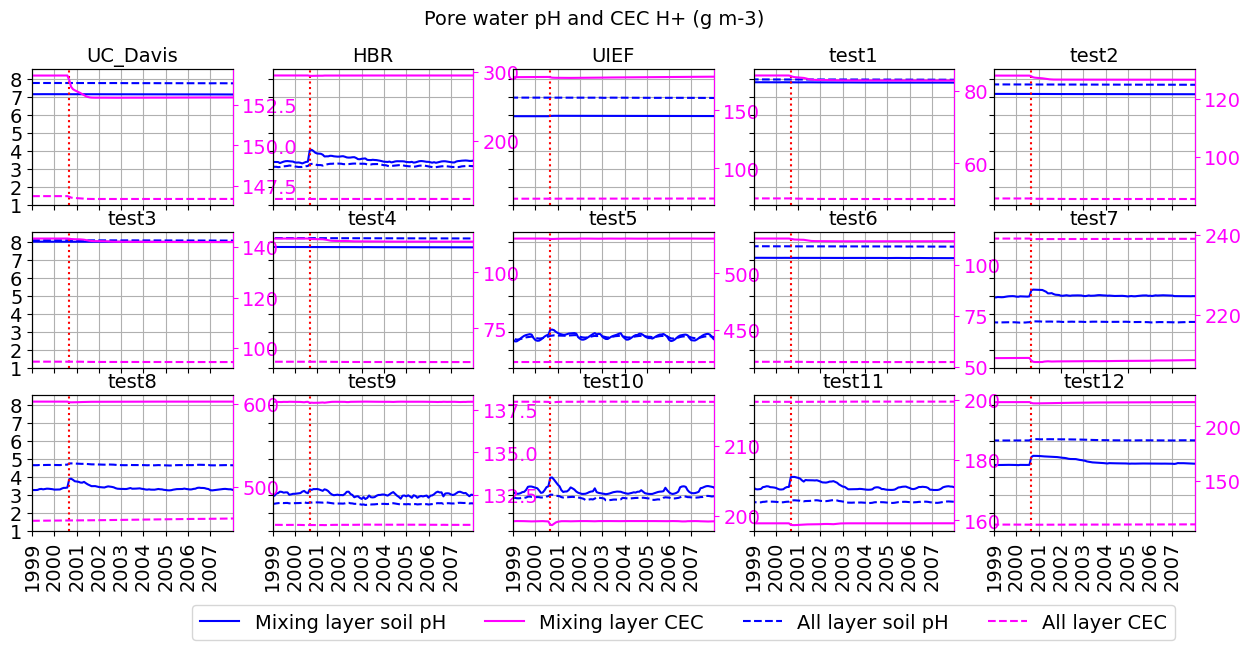

In [15]:
# plot soil pH and CEC H+ on the same graph
fig, axes = plt.subplots(3, 5, figsize = (15, 6), sharex = True, sharey = True)
for i, site in enumerate(site_list.index):
    ax = axes.flat[i]
    ax2 = ax.twinx()

    h = []
    for layer, ls in zip(['mixing_depth', 'full_depth'], ['-', '--']):
        htemp, = ax.plot(soil_pH.index, soil_pH[(site,layer)], color = 'b', ls = ls)
        h.append(htemp)
        htemp, = ax2.plot(cec_proton.index, cec_proton[(site,layer)], color = 'magenta', ls = ls)
        h.append(htemp)

    ax.set_title(site)
    ax.axvline(pd.Timestamp('2000-09-01'), color = 'r', ls = ':')
    plt.setp(ax.get_xticklabels(), rotation = 90)
    ax.set_yticks(np.arange(1, 8.1, 1))
    ax.grid(True)
    ax.set_xlim([pd.Timestamp('1999-01-01'), pd.Timestamp('2007-12-31')])

    ax2.yaxis.set_label_position('right')
    ax2.yaxis.tick_right()
    ax2.spines['right'].set_color('magenta')
    ax2.tick_params(axis='y', colors='magenta')

ax.legend(h, ['Mixing layer soil pH','Mixing layer CEC','All layer soil pH','All layer CEC'],
          loc = [-4, -0.8], ncol = 4)
fig.suptitle('Pore water pH and CEC H+ (g m-3)', fontsize = 14)
plt.savefig(os.path.join(path_out, 'compare_proton_state.png'), 
            dpi = 600., bbox_inches = 'tight')
#plt.close()

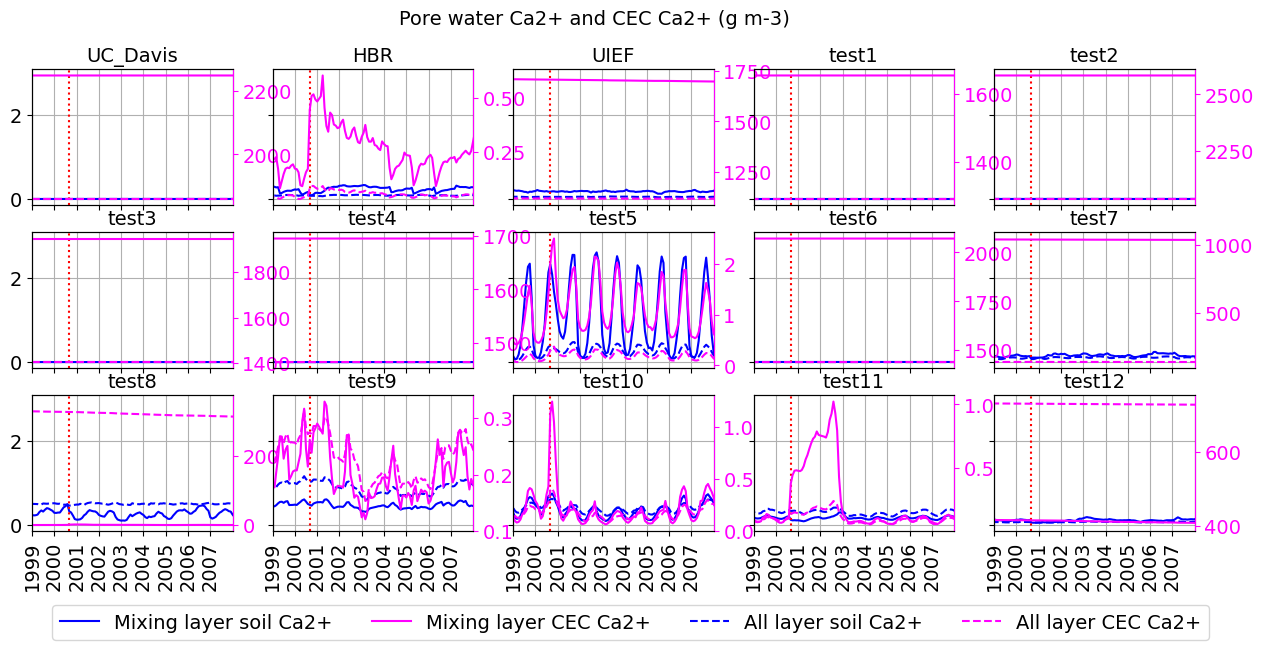

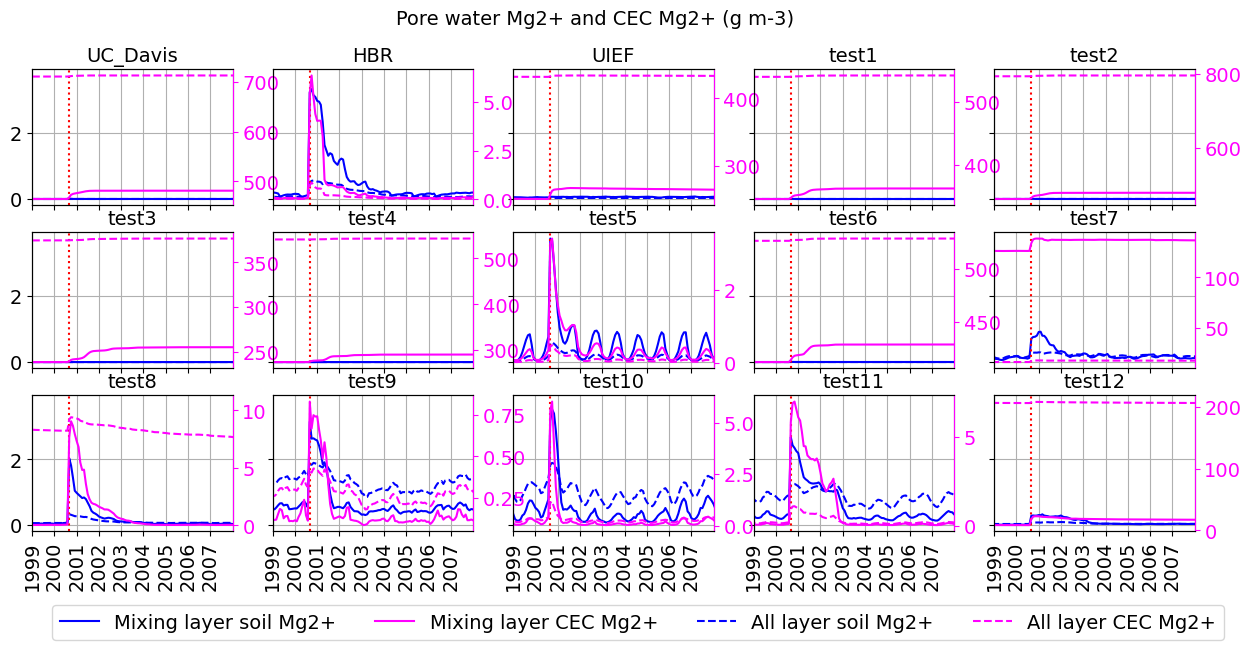

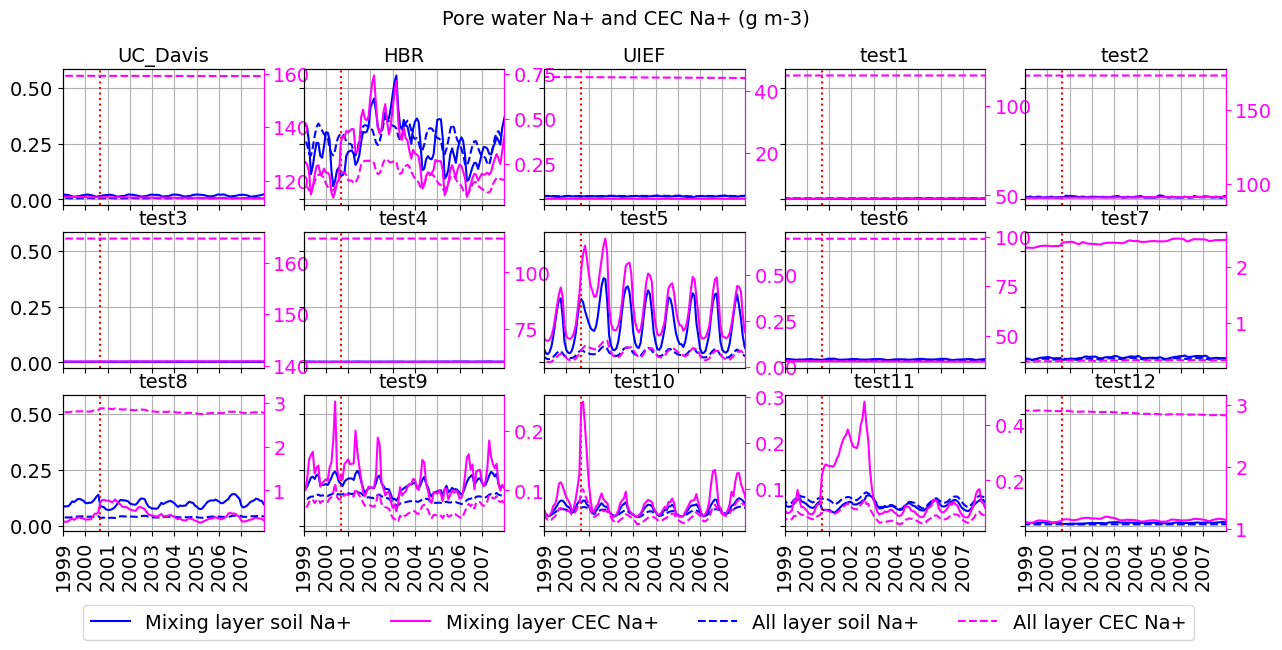

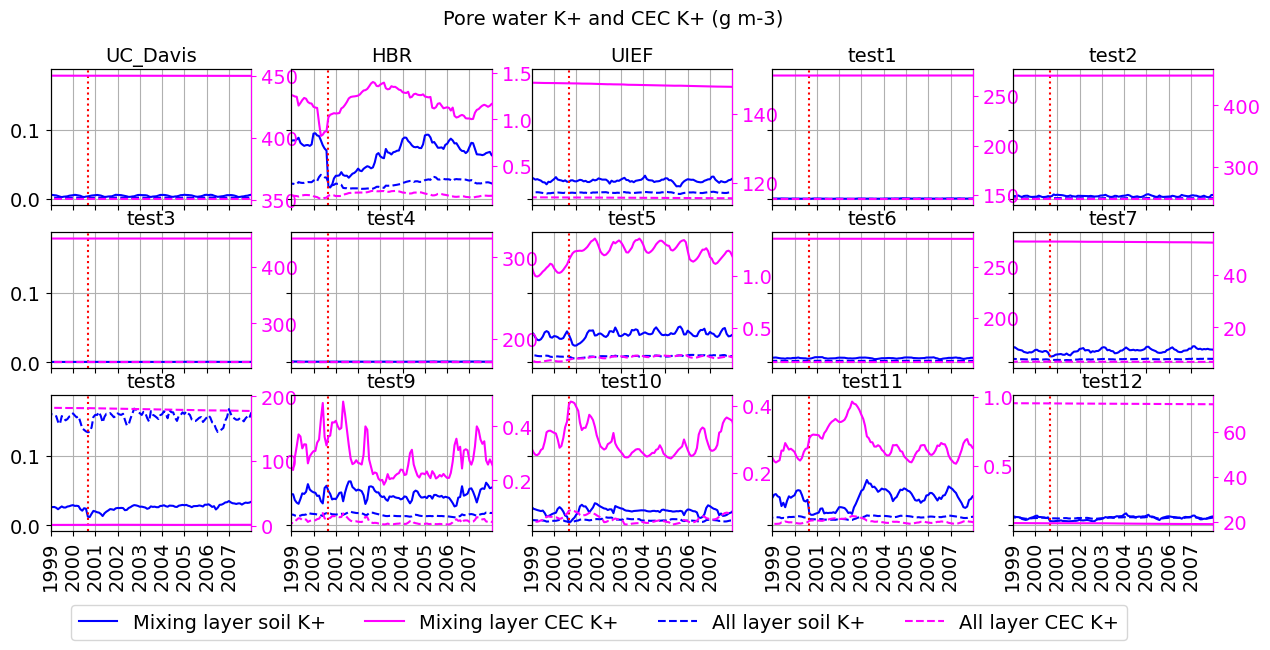

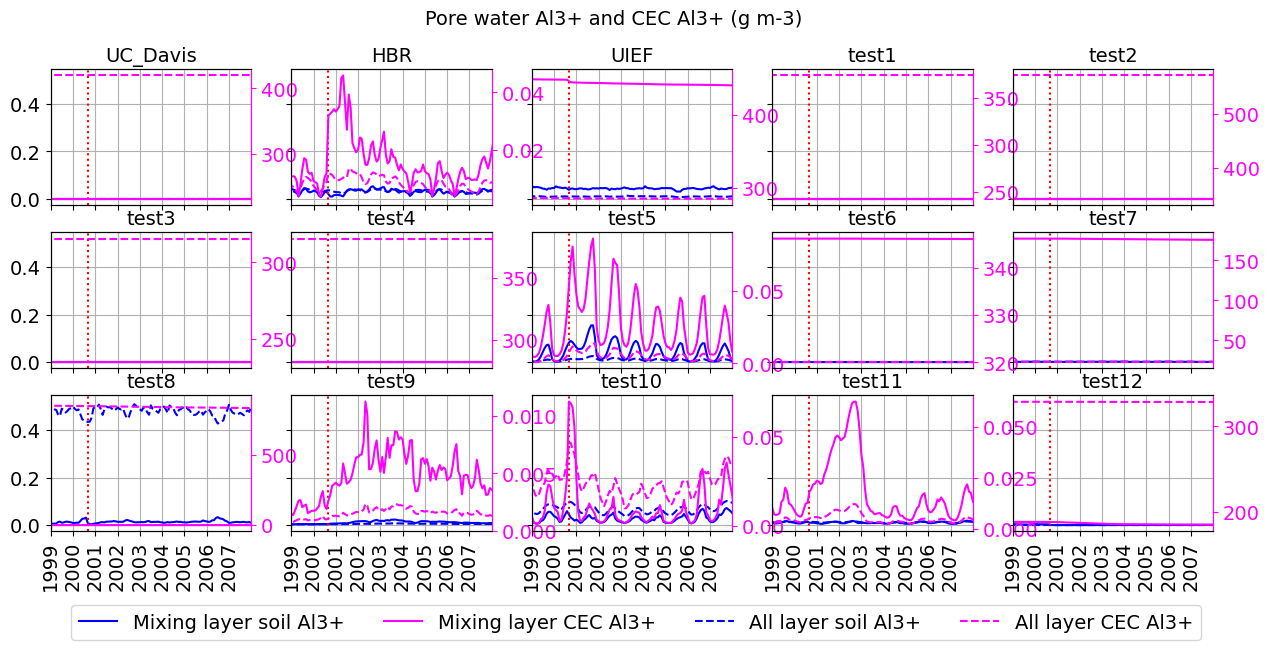

In [16]:
# plot soil pore water cation and CEC cation on the same graph
for icat,ion in enumerate(cations):
    fig, axes = plt.subplots(3, 5, figsize = (15, 6), sharex = True, sharey = True)
    for i, site in enumerate(site_list.index):
        ax = axes.flat[i]
        ax2 = ax.twinx()

        h = []
        for layer, ls in zip(['mixing_depth', 'full_depth'], ['-', '--']):
            htemp, = ax.plot(soil_cation.index, soil_cation[(ion,site,layer)], color = 'b', ls = ls)
            h.append(htemp)
            htemp, = ax2.plot(cec_cation.index, cec_cation[(ion,site,layer)], 
                              color = 'magenta', ls = ls)
            h.append(htemp)

        ax.set_title(site)
        ax.axvline(pd.Timestamp('2000-09-01'), color = 'r', ls = ':')
        plt.setp(ax.get_xticklabels(), rotation = 90)
        ax.grid(True)
        ax.set_xlim([pd.Timestamp('1999-01-01'), pd.Timestamp('2007-12-31')])

        ax2.yaxis.set_label_position('right')
        ax2.yaxis.tick_right()
        ax2.spines['right'].set_color('magenta')
        ax2.tick_params(axis='y', colors='magenta')

    ax.legend(h, [f'Mixing layer soil {ion}', f'Mixing layer CEC {ion}',
                  f'All layer soil {ion}', f'All layer CEC {ion}'],
            loc = [-4.7, -0.8], ncol = 4)
    fig.suptitle(f'Pore water {ion} and CEC {ion} (g m-3)', fontsize = 14)
    plt.savefig(os.path.join(path_out, f'compare_cation_state_{icat}.png'), 
                dpi = 600., bbox_inches = 'tight')
    #plt.close()

## 2.4 Cation dynamics

 background weathering
 
 primary cation flux
 
 CEC cation flux
 
 secondary cation flux
 
 cation_infl_vr
 
 cation_leached_vr
 
 cation_runoff_vr

## 2.5 Secondary mineral formation